In [1]:
import pandas as pd
import altair as alt
import madmom
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from fastai.data.transforms import get_files
import snoop
from alive_progress import alive_it

%matplotlib inline

/home/laurenz/.cache/pypoetry/virtualenvs/music-processing-6AESlpXO-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**question**: how consistent is the beat spacing?

-> this is important, because the idea I have heavily relies on the asumption of consitent spacing...

In [2]:
files = list(
    map(
        lambda file: str(file)[:-3] + "beats.gt",
        get_files("../data/raw/train/", extensions=".wav"),
    )
)

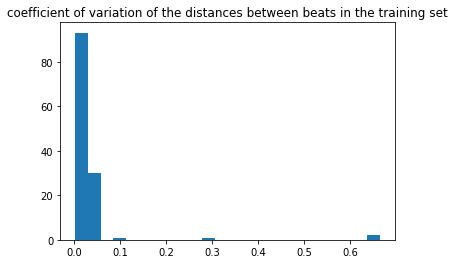

In [3]:
beats = [madmom.io.load_events(file) for file in files]
plt.title("coefficient of variation of the distances between beats in the training set")
plt.hist([scipy.stats.variation(np.diff(beat)) for beat in beats], bins=24);

-> given that most entries have a very small coefficient of variation, I think the asumption of consistent beats should hold true.

In [4]:
file = "../data/raw/train/Media-103611(8.2-18.2).wav"
Audio(file)

In [5]:
sig = madmom.audio.signal.Signal(file)
sig = sig[: len(sig) // 8]
onsets = madmom.io.load_events(str(file)[:-4] + ".onsets.gt")
onsets = onsets[: len(onsets) // 8]
beats = madmom.io.load_events(str(file)[:-4] + ".beats.gt")
beats = beats[: len(beats) // 8]

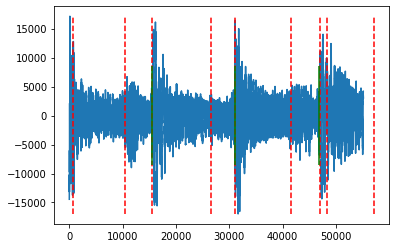

In [6]:
plt.plot(sig)
plt.vlines(onsets * 44100, color="red", linestyle="--", ymin=min(sig), ymax=max(sig))
plt.vlines(beats * 44100, color="green", ymin=min(sig) / 2, ymax=max(sig) / 2)

In [7]:
onsets

array([0.01741497, 0.23873016, 0.35265306, 0.60204082, 0.70240363,
       0.94183673, 1.06376417, 1.09387755, 1.29387755])

In [8]:
t = np.arange(0, 1.29, 1 / 44100, dtype=float)

In [9]:
def gaussian(x, mu, std):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(std, 2.0)))

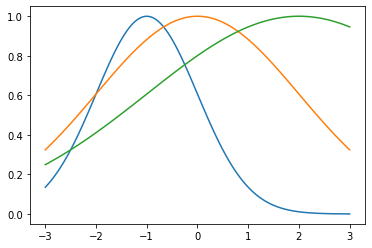

In [10]:
x_values = np.linspace(-3, 3, 120)
for mu, std in [(-1, 1), (0, 2), (2, 3)]:
    plt.plot(x_values, gaussian(x_values, mu, std))

plt.show()

In [11]:
def gaussian_train(bpm, offset, signal_length, gaus_width):
    x = np.arange(0, signal_length, 1 / 44100, dtype=float)
    num_beats = int(np.ceil((signal_length - offset) * bpm / 60))
    gaus_train = np.zeros_like(x)
    for beat_idx in range(num_beats):
        gaus_train += gaussian(x, offset + beat_idx * 60 / bpm, gaus_width / 4)

    return gaus_train, num_beats

In [12]:
gaus, num_beats = gaussian_train(120, 0.2, 1.3, 0.075)

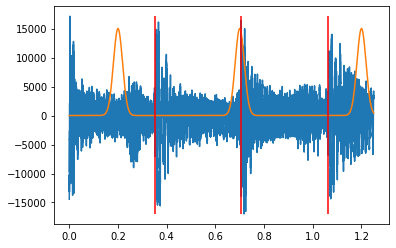

In [13]:
x = np.arange(0, 1.3, 1 / 44100, dtype=float)
plt.plot(x[:55125], sig)
plt.plot(x[:55125], gaus[:55125] * 15000)
plt.vlines(beats, color="red", ymin=min(sig), ymax=max(sig))

In [14]:
beats

array([0.35265306, 0.70408163, 1.06326531])

In [15]:
def time2idx(time: float) -> int:
    return int(time * 44100)

In [16]:
list(map(time2idx, beats))

[15551, 31049, 46889]

In [17]:
def score(gaus_train, beats, num_beats):
    return sum([gaus_train[time2idx(beat)] for beat in beats]) / num_beats

In [18]:
score(gaus, beats, num_beats)

0.32561369450802286

lets apply this to scoring in a bpm sweep for one file and look at the results

In [19]:
fits = {}
for bpm in alive_it(range(50, 210, 10), force_tty=True):
    gaus, num_beats = gaussian_train(bpm, 0.0, 1.3, 0.075)
    fit = score(gaus, beats, num_beats)
    fits[str(bpm)] = {"gaus": gaus, "num_beats": num_beats, "fit": fit}

|████████████████████████████████████████| 16/16 [100%] in 0.3s (47.04/s)                                               


In [20]:
fits

{'50': {'gaus': array([1.00000000e+00, 9.99999269e-01, 9.99997075e-01, ...,
         6.78841043e-07, 6.74479083e-07, 6.70144172e-07]),
  'num_beats': 2,
  'fit': 1.4030545569598564e-12},
 '60': {'gaus': array([1.00000000e+00, 9.99999269e-01, 9.99997075e-01, ...,
         2.72592689e-56, 2.67369713e-56, 2.62246427e-56]),
  'num_beats': 2,
  'fit': 0.0016925647935620567},
 '70': {'gaus': array([1.00000000e+000, 9.99999269e-001, 9.99997075e-001, ...,
         7.93562597e-122, 7.71218592e-122, 7.49502621e-122]),
  'num_beats': 2,
  'fit': 1.675825407156645e-15},
 '80': {'gaus': array([1.00000000e+000, 9.99999269e-001, 9.99997075e-001, ...,
         1.59617218e-187, 1.54054632e-187, 1.48685681e-187]),
  'num_beats': 2,
  'fit': 0.02485092853915802},
 '90': {'gaus': array([1.00000000e+000, 9.99999269e-001, 9.99997075e-001, ...,
         2.00272838e-248, 1.92257258e-248, 1.84562219e-248]),
  'num_beats': 2,
  'fit': 0.06844843162263975},
 '100': {'gaus': array([1.00000000e+00, 9.99999269e-01,

In [21]:
bpms = [int(key) for key, _ in fits.items()]

In [22]:
scores = [value["fit"] for key, value in fits.items()]

<StemContainer object of 3 artists>

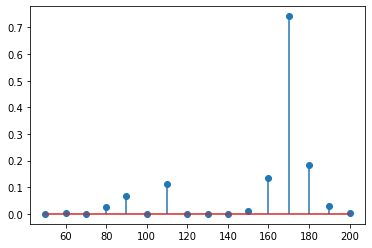

In [23]:
plt.stem(bpms, scores)

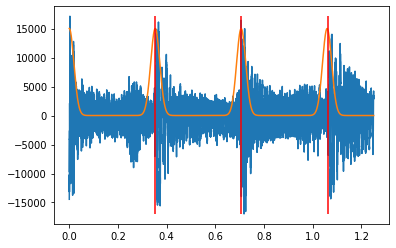

In [24]:
x = np.arange(0, 1.3, 1 / 44100, dtype=float)
plt.plot(x[:55125], sig)
plt.plot(x[:55125], fits["170"]["gaus"][:55125] * 15000)
plt.vlines(beats, color="red", ymin=min(sig), ymax=max(sig))

-> what a nice result!

lets look at some examples with lower scores

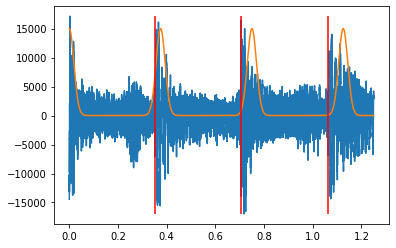

In [25]:
x = np.arange(0, 1.3, 1 / 44100, dtype=float)
plt.plot(x[:55125], sig)
plt.plot(x[:55125], fits["160"]["gaus"][:55125] * 15000)
plt.vlines(beats, color="red", ymin=min(sig), ymax=max(sig))

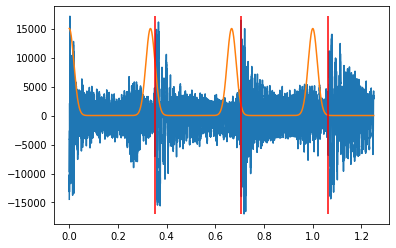

In [26]:
x = np.arange(0, 1.3, 1 / 44100, dtype=float)
plt.plot(x[:55125], sig)
plt.plot(x[:55125], fits["180"]["gaus"][:55125] * 15000)
plt.vlines(beats, color="red", ymin=min(sig), ymax=max(sig))

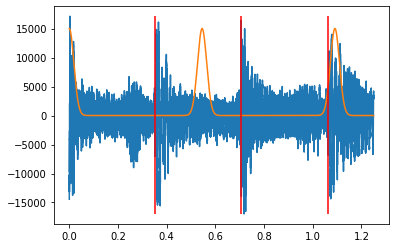

In [27]:
x = np.arange(0, 1.3, 1 / 44100, dtype=float)
plt.plot(x[:55125], sig)
plt.plot(x[:55125], fits["110"]["gaus"][:55125] * 15000)
plt.vlines(beats, color="red", ymin=min(sig), ymax=max(sig))

lets look at the average time to the first beat to now how long we should sweep the offset

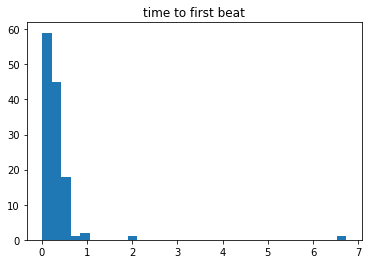

In [28]:
beats = [madmom.io.load_events(file) for file in files]
plt.title("time to first beat")
plt.hist([beat[0] for beat in beats], bins=32);

lets try increasing the score by sweeping over offsets

In [29]:
sig = madmom.audio.signal.Signal(file)
sig = sig[: len(sig) // 8]
onsets = madmom.io.load_events(str(file)[:-4] + ".onsets.gt")
onsets = onsets[: len(onsets) // 8]
beats = madmom.io.load_events(str(file)[:-4] + ".beats.gt")
beats = beats[: len(beats) // 8]

fits = []
for bpm in alive_it(range(50, 210, 10), force_tty=True):
    for offset in np.linspace(0.0, 1.0, 15):
        gaus, num_beats = gaussian_train(bpm, offset, 1.3, 0.075)
        fit = score(gaus, beats, num_beats)
        fits.append(
            {
                "bpm": bpm,
                "offset": offset,
                "gaus": gaus,
                "num_beats": num_beats,
                "fit": fit,
            }
        )

|████████████████████████████████████████| 16/16 [100%] in 1.6s (9.83/s)                                                


In [30]:
df = pd.DataFrame(fits)

In [ ]:
alt.Chart(df).mark_rect().encode(
    alt.X("bpm:O"), alt.Y("offset:Q", bin=alt.Bin(maxbins=15)), color="fit:Q"
)

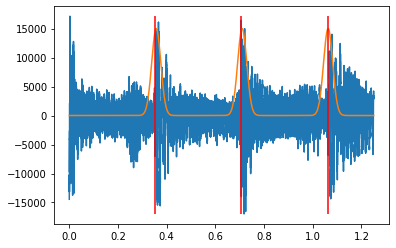

In [71]:
x = np.arange(0, 1.3, 1 / 44100, dtype=float)
plt.plot(x[:55125], sig)
plt.plot(
    x[:55125],
    df[(df["bpm"] == 170) & (0.3 <= df["offset"]) & (df["offset"] <= 0.4)][
        "gaus"
    ].to_numpy()[0][:55125]
    * 15000,
)
plt.vlines(beats, color="red", ymin=min(sig), ymax=max(sig))

## onset selection

after determining the gaussian train with the highest score, we need to filter out the onsets, that are not close to the peaks of the gaussian train. 

In [72]:
onsets

array([0.01741497, 0.23873016, 0.35265306, 0.60204082, 0.70240363,
       0.94183673, 1.06376417, 1.09387755, 1.29387755])

In [73]:
train = df[(df["bpm"] == 170) & (0.3 <= df["offset"]) & (df["offset"] <= 0.4)][
    "gaus"
].to_numpy()[0]

In [74]:
train

array([1.64596470e-79, 1.68431945e-79, 1.72356543e-79, ...,
       2.15657272e-35, 2.12386825e-35, 2.09165668e-35])

In [93]:
def get_index_from_timestamp(timestamp, sampling_rate=44100):
    return int(timestamp * sampling_rate)


def get_timestamp_from_index(idx, sampling_rate=44100):
    return idx / sampling_rate

In [78]:
onsets_idx = list(map(get_index_from_timestamp, onsets))

In [79]:
onsets_idx

[767, 10527, 15551, 26549, 30975, 41534, 46911, 48239, 57059]

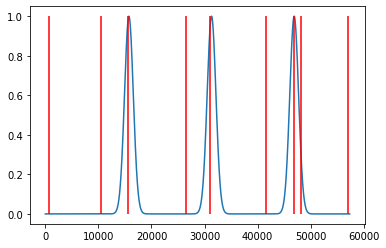

In [81]:
plt.plot(train)
plt.vlines(onsets_idx, color="red", ymin=min(train), ymax=max(train))

In [90]:
beats_idx = list(filter(lambda idx: train[idx] > 0.5, onsets_idx))

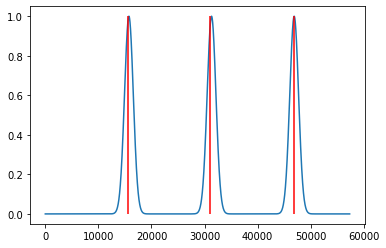

In [91]:
plt.plot(train)
plt.vlines(beats_idx, color="red", ymin=min(train), ymax=max(train))

In [94]:
beats = list(map(get_timestamp_from_index, beats_idx))

In [95]:
beats

[0.35263038548752834, 0.7023809523809523, 1.0637414965986394]